# Machine Learning for Medicine
## Lab IV - Feature Selection
*Badis Jaouani - M2 Statistics*
___

In this lab, we are interested in applying feature sellection methods. Recall the three families of method seen during the lecture: 

1. Filter methods from which we apply the Variance Threshol (VT) and the False Discovery Rate (FDR) in order to select the features with large variance.

2. Wrapper methods which are not considered in this lab.

3. Embedded methods which select the most informative features according to machine learning algorithms. To do so, we make use of sparsity via $L_1$ regularization.   

The above methods are assessed on two different data sets, one with few features, the Breast Cancer Diagnosis, and the other with much more features corresponding to gene expressions. 

# Table of contents
___

1. [Breast Cancer Data Set](#Breast)
    - [Classifiction using the whole data set](#Import)
    - [Filter Methods](#Import)
    - [Statistical tests](#Import)
    - [$\mathcal{L}_1$- based feature selection](#import)
        - [Logistic Regression with $\mathcal{L}_1$ penalty (LASSO)](#Import)
        - [Support Vector Machine with $\mathcal{L}_1$ penalty](#Import)
        - [Elastic Net regularization](#Import)
2. [Molecular classification of leukemia data set](#Import)
    - [Classifiction using the whole data set](#Import)
    - [Filter Methods](#Import)
    - [Statistical tests](#Import)
    - [$\mathcal{L}_1$- based feature selection](#import)
        - [Logistic Regression with $\mathcal{L}_1$ penalty (LASSO)](#Import)
        - [Support Vector Machine with $\mathcal{L}_1$ penalty](#Import)
        - [Elastic Net regularization](#Import)
3. [Conclusion](#Import)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, HTML
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

# I. Breast Cancer Data set
___
We start by importing the data of interest.

In [2]:
breast_cancer = pd.read_table('BreastDiagnostic.txt', sep = ',', header = None)

In [3]:
display(HTML(
    f"Number of attributes: {breast_cancer.shape[1] - 2} <br/>"
    f"Number of patients: {breast_cancer.shape[0]} <br/>"))

The number of features is not very high in this data set, but we will see that not all of them are equally informative. We do some preprcessing first, similarly to the previous lab.

In [4]:
# Fast pre processing (similar to the previous lab)
from sklearn.preprocessing import minmax_scale, OrdinalEncoder

y_bc = breast_cancer.loc[:,1]
X_bc = breast_cancer.drop(columns = [0,1])
X_bc = pd.DataFrame(minmax_scale(X_bc))
enc = OrdinalEncoder()
breast_cancer.loc[:,1] = enc.fit_transform(breast_cancer.loc[:,1].to_numpy().reshape(-1,1))
y_bc = enc.fit_transform(y_bc.to_numpy().reshape(-1,1))

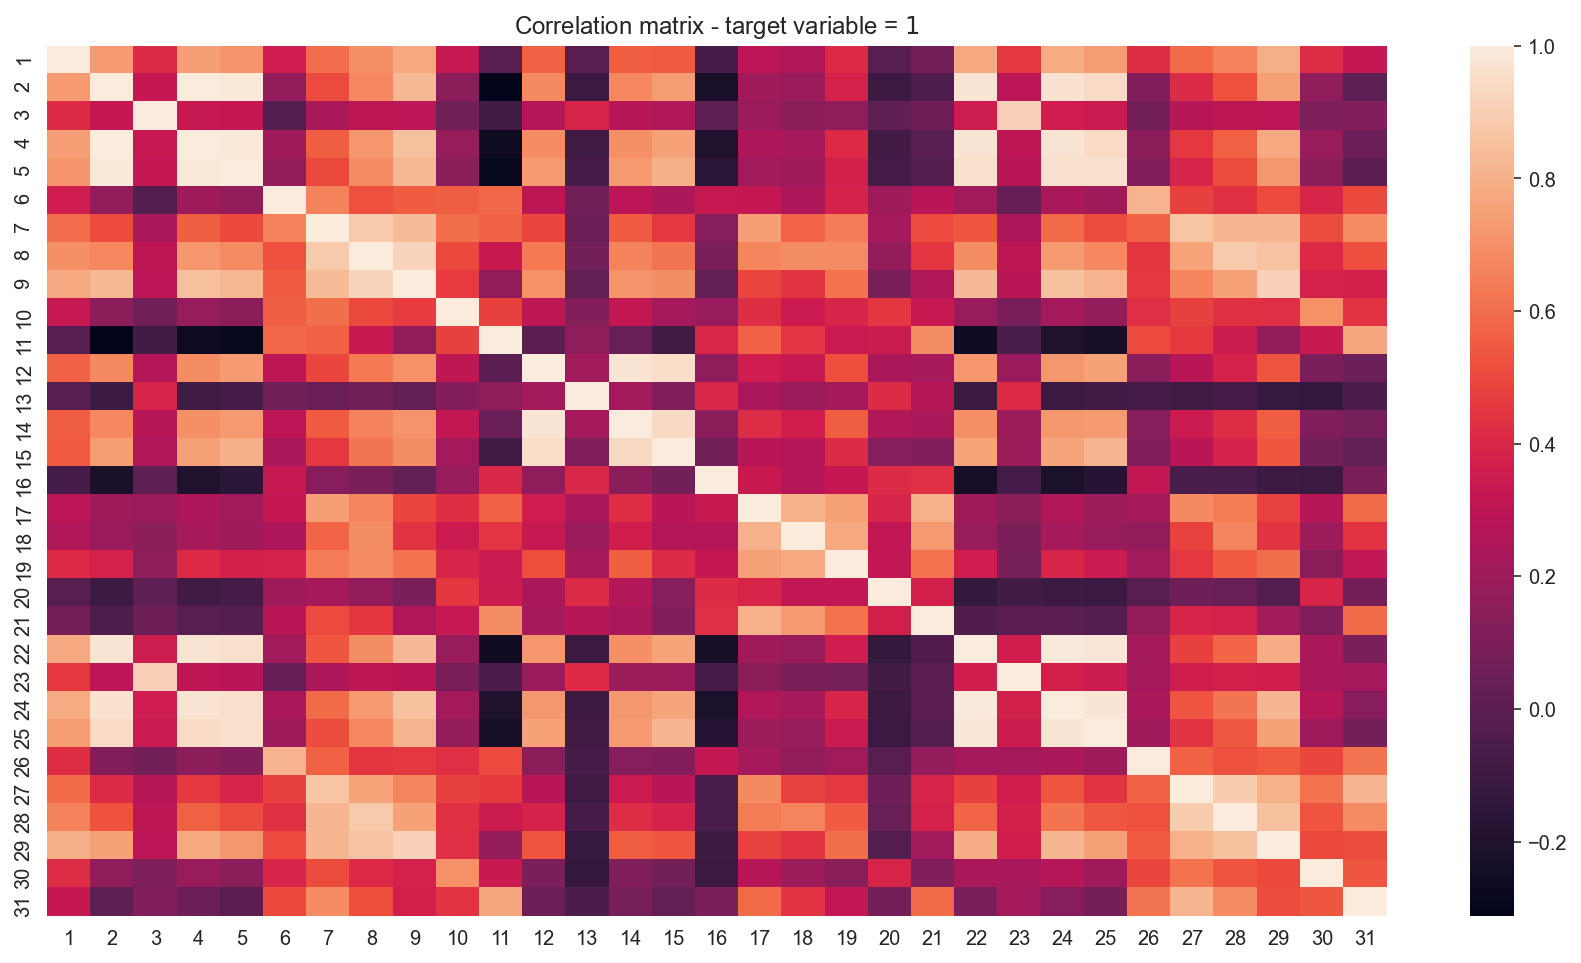

In [5]:
plt.figure(figsize = (15,8))
sns.heatmap(breast_cancer.loc[:,1:].corr())
plt.title('Correlation matrix - target variable = $1$');

The correlation matrix shows the target variable (1) is correlated (or inversly correlated) with many features, but when selecting the most informative ones, correlations between the features makes it possible to reduce the number of predictors. In the above example, we can see that feature (2) is extremely correlated with (4) and (5).

Let us start by using all the variables to run a classification algorithm, and see the results.

## 1. Classifiction using the whole data set
We use a Linear SVM for classification.

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_bc, y_bc, test_size = 0.25, random_state = 0)

In [7]:
from sklearn.svm import SVC

svc1 = SVC(C = 1, kernel = 'linear', probability = True)
svc1.fit(X_train, y_train.reshape(-1,))

SVC(C=1, kernel='linear', probability=True)

In [8]:
k = 5
cv1 = cross_validate(svc1, X_train, y_train, cv = k,
                     scoring = ['balanced_accuracy', 'roc_auc_ovr_weighted', 'accuracy'],
                     n_jobs = -1)

In [9]:
display(HTML(
    f"5-fold cross-validation: <br/>"
    f"Balanced Accuracy: {cv1['test_balanced_accuracy']} <br/>"
    f"Balanced roc_auc: {cv1['test_roc_auc_ovr_weighted']} <br/>"
    f"Accuracy: {cv1['test_accuracy']} <br/>"
))

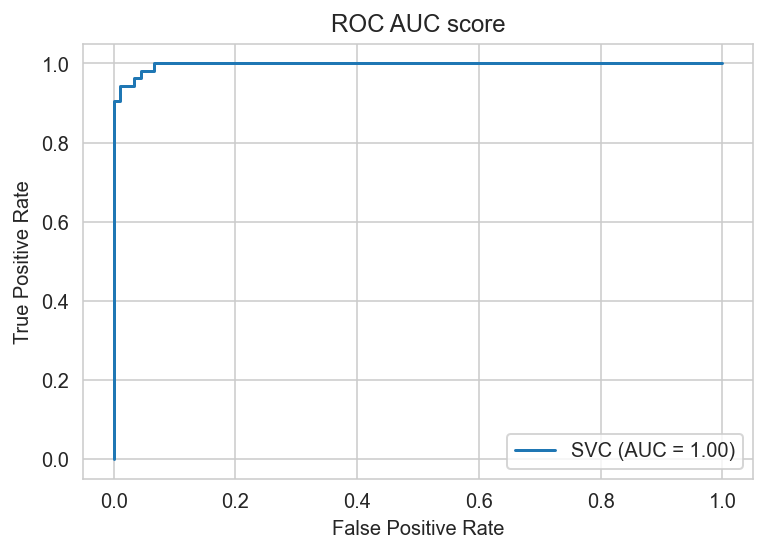

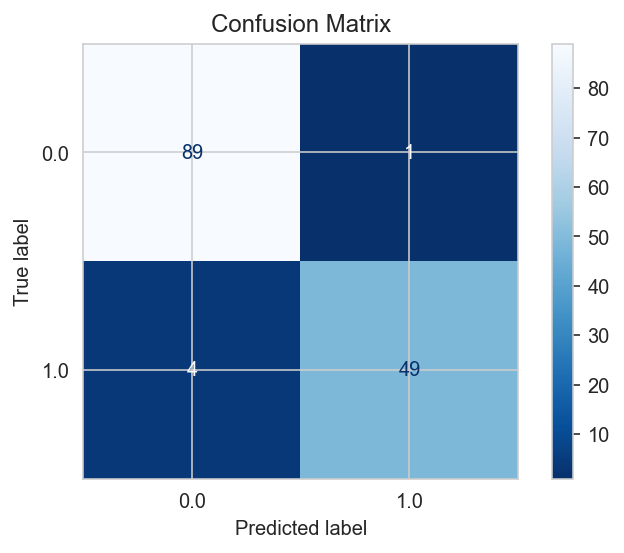

In [10]:
plot_roc_curve(svc1, X_test, y_test)
plt.title('ROC AUC score')

plot_confusion_matrix(svc1, X_test, y_test, cmap = 'Blues_r')
plt.title('Confusion Matrix');

The results above show that a linear SVM performs very well in predicting whether the patient has cancer or not. The aim of what is coming next is to obtain similar results using less features, meaning that we try to detect the most informative features in Breast Cancer diagnosis.

## 2. Filter Methods
We start by one of the most basic approaches, which is to select the features of which the variance is above an arbitrary threshold.

In [11]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_bc, y_bc, test_size = 0.25, random_state = 0)

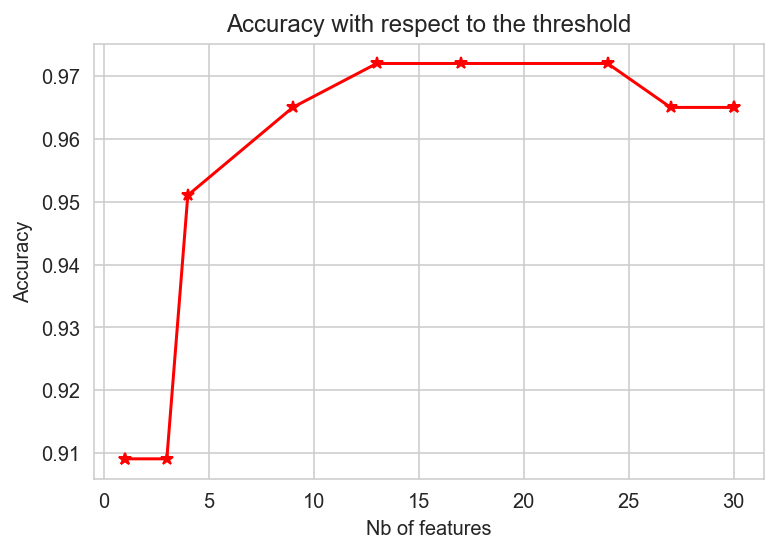

In [12]:
from sklearn.feature_selection import VarianceThreshold


threshold = [k*X_bc.var().mean() for k in np.arange(0,2.2,0.2)]
accuracy, nb_features = [], []

for thd in threshold:
    # Fit the variance threshold selector
    selector = VarianceThreshold(threshold = thd)
    selector.fit_transform(X_train)
    idx = selector.get_support(indices = True)
    X_new = X_train.copy()
    X_new.loc[:,~X_new.columns.isin(idx)] = 0
    nb_features.append(idx.shape[0])
    
    # Display the selected number of features 
    display(HTML(
    f"threshold: {thd} <br/>"
    f"Number of attributes: {idx.shape[0]} <br/>"
    f"Number of retained features: {idx} <br/>"
    ))
    
    # Fit the classifier
    svc = SVC(C = 1, kernel = 'linear', probability = True)
    svc.fit(X_new, y_train.reshape(-1,))
    accuracy.append(svc.score(X_test, y_test))

    
# Plot the accuracy
plt.plot(nb_features, accuracy, '-*', color = 'red')
plt.xlabel('Nb of features')
plt.ylabel('Accuracy')
plt.title('Accuracy with respect to the threshold');

What is observed in the figure is that selecting more features increases the accuracy of the algorithm. The best accuracy is achieved for a number of retained features that is lower than the total 30 initial predictors, meaning that some features, with low variance, are non-informative.

## 3. Statistical tests
A second method, based on the False Discovery Rate, could be used for feature selection. The alpha parameter in this algorithm controls whether more features are selected or not.

In [13]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_bc, y_bc, test_size = 0.25, random_state = 0)

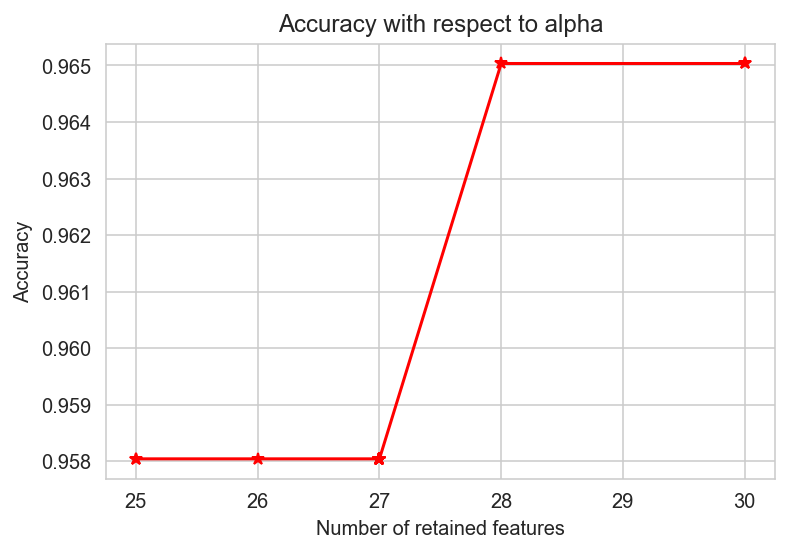

In [14]:
from sklearn.feature_selection import SelectFdr, f_classif

accuracy, nb_features, indices  = [], [], []
alpha = np.arange(5e-3, 1, 5e-2)

for alph in alpha:
    # Fit the False Discovery Rate selector
    selector_fdr = SelectFdr(score_func = f_classif, alpha = alph)
    selector_fdr.fit(X_bc, y_bc.reshape(-1,))
    idx = selector_fdr.get_support(indices = True)
    X_new = X_train.copy()
    X_new.loc[:,~X_new.columns.isin(idx)] = 0
    nb_features.append(idx.shape[0])
    indices.append(selector_fdr.get_support(indices = True))
    
    
    # Display the selected number of features 
    display(HTML(
    f"Alpha: {alph} <br/>"
    f"Number of retained attributes: {idx.shape[0]} <br/>"
    f"Retained indices: {idx} <br/>"
    ))
    
    # Fit the classifier
    svc = SVC(C = 1, kernel = 'linear', probability = True)
    svc.fit(X_new, y_train.reshape(-1,))
    accuracy.append(svc.score(X_test, y_test))

    
# Plot the accuracy
plt.plot(nb_features, accuracy, '-*', color = 'red')
plt.xlabel('Number of retained features')
plt.ylabel('Accuracy')
plt.title('Accuracy with respect to alpha');

As the figure suggests, more features imply a slightly increasing accuracy, but this method, even with very small $\alpha$, selects many of the features, which is not of interest especially when the initial number of predictors is very high, like the one in the second part of this lab. 

We may be interested make the selection process as part of the learning process, this is the object of the upcoming section.

## 4. $\mathcal{L}_1$- based feature selection
The idea behind the coming methods is to select the most informative features based on a $L_1$ regularization, which is known to return sparse solutions, ie selects some of the features. A crucial hyperparameter is the importance we give to the regularization. Below, we present three methods that use the $L_1$ penalty, which are the 

### 4.1) Logistic Regression with $\mathcal{L}_1$ penalty (LASSO)
The empirical risk is penalized by the $L_1$ norm $\|\, .\|_1$. We run the algorithm with different values of the inverse of the regularization parameter.

In [15]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_bc, y_bc, test_size = 0.25, random_state = 0)

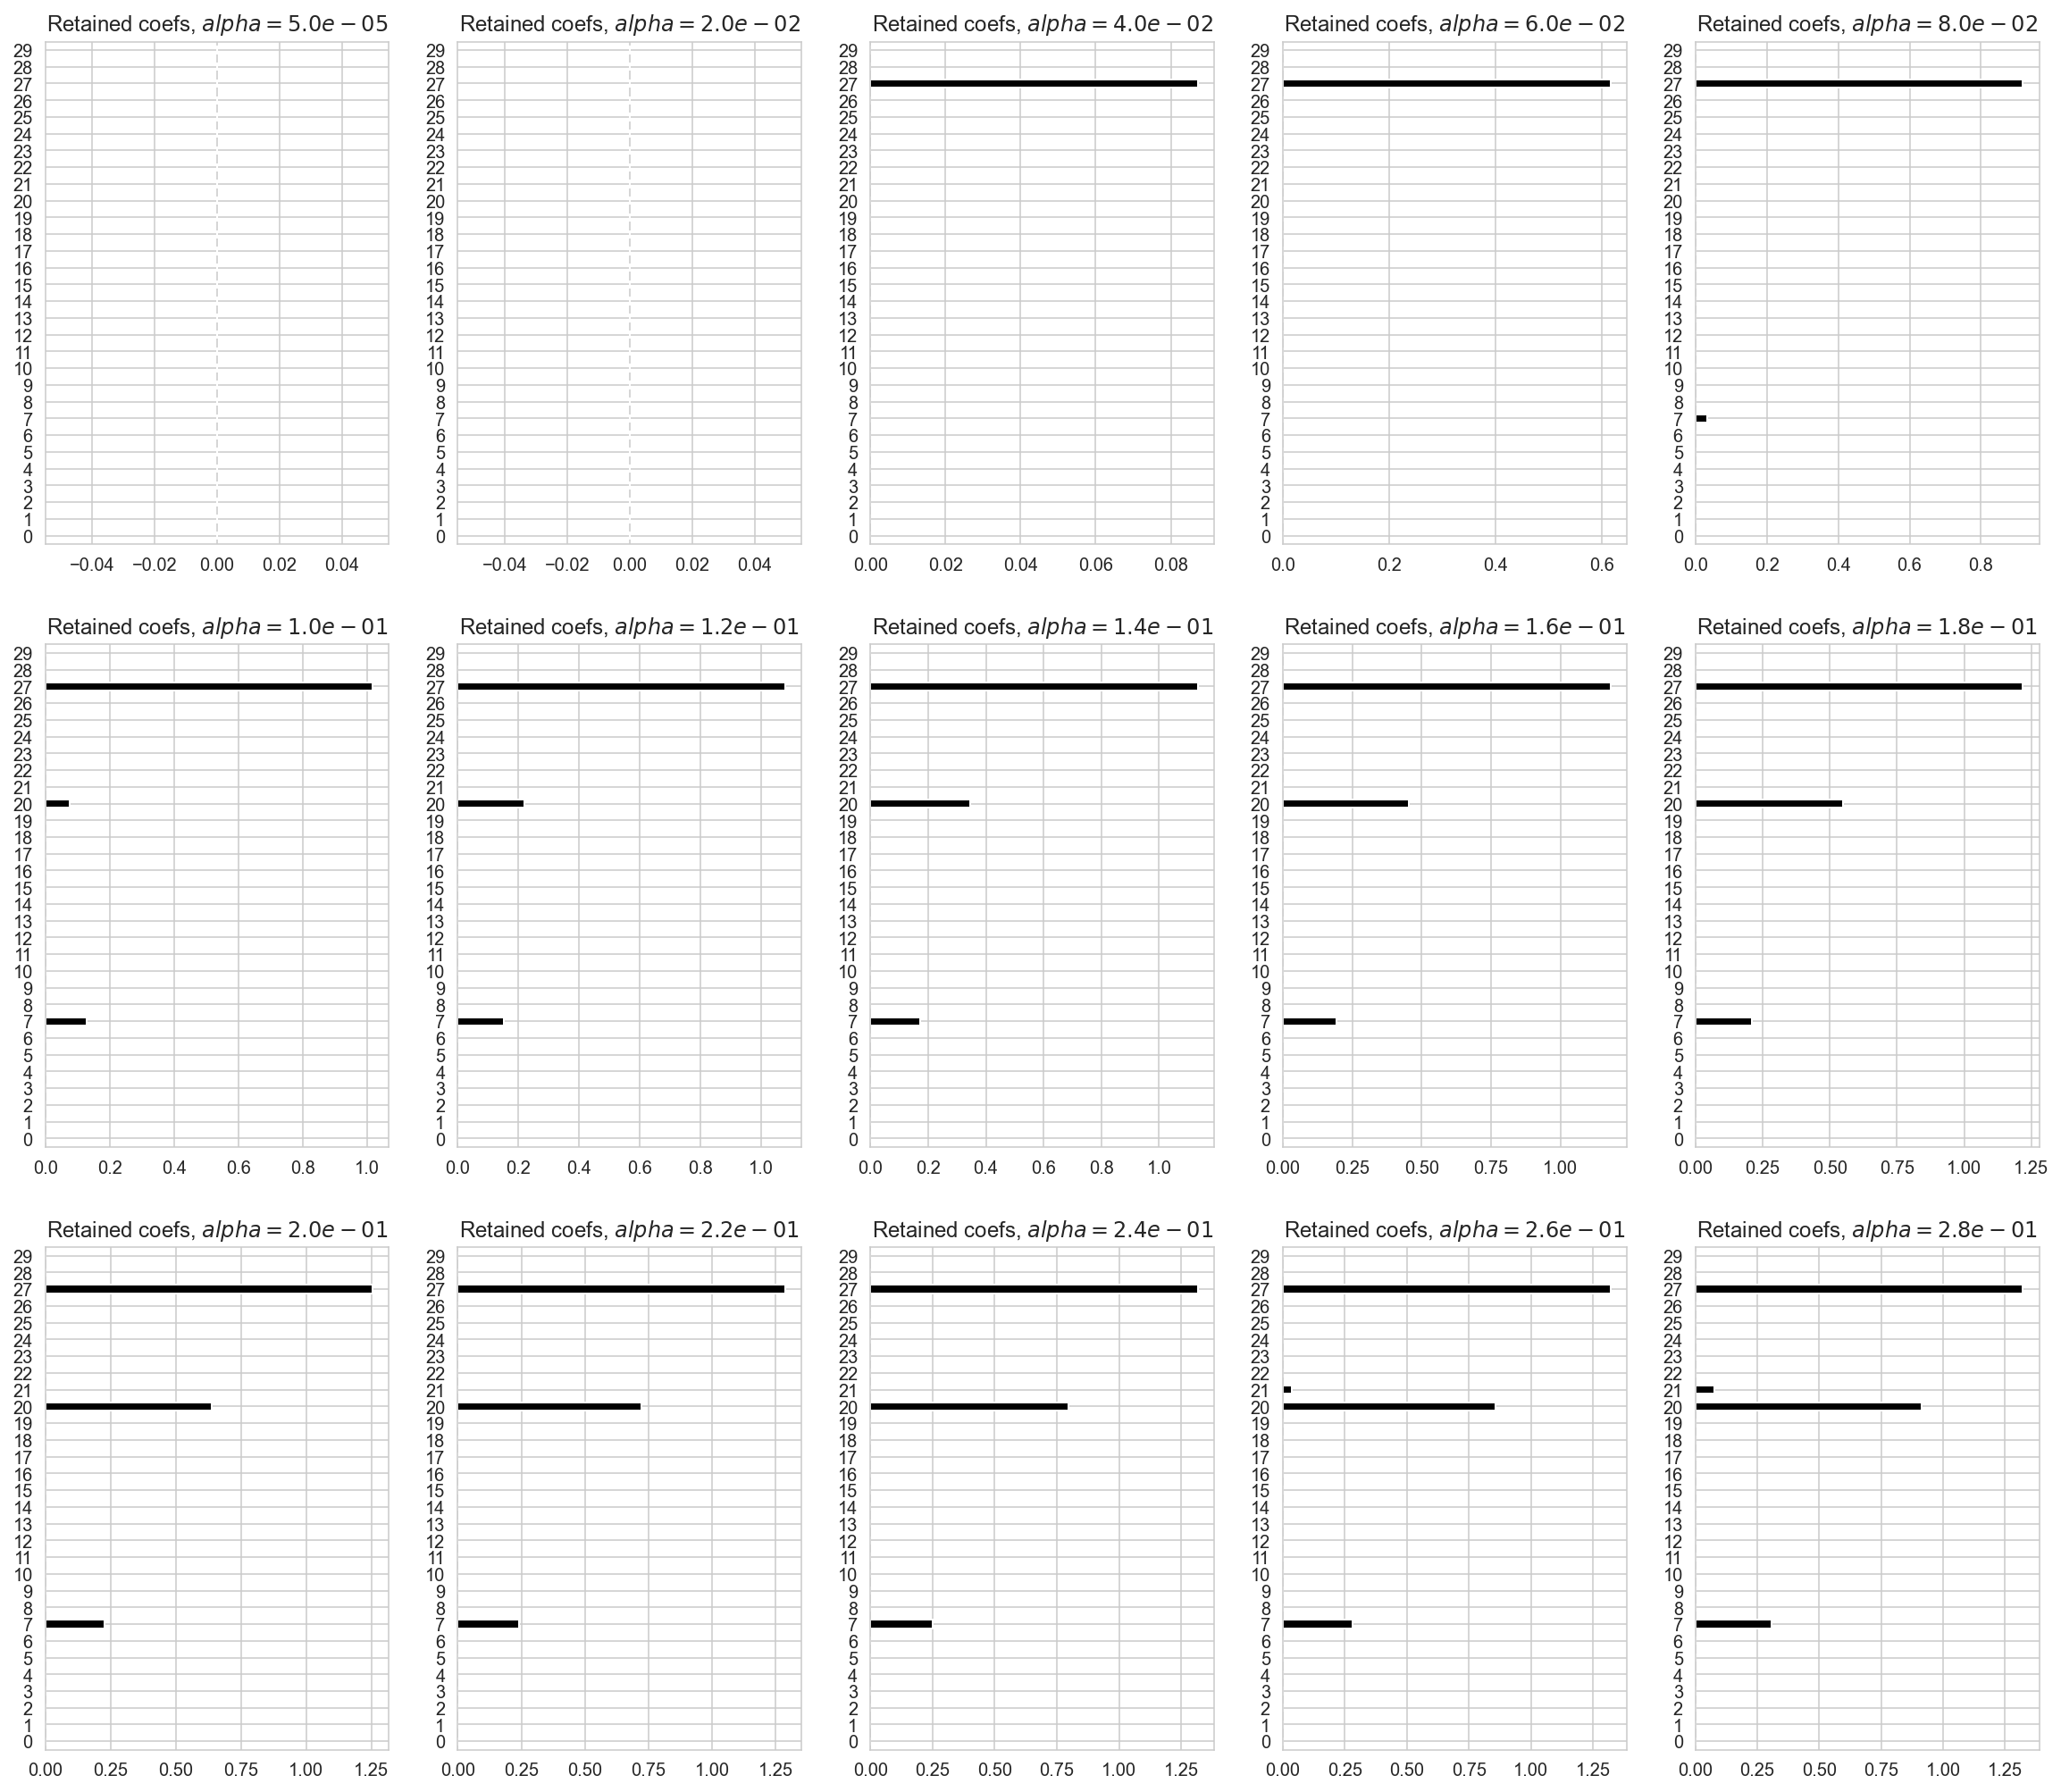

In [16]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression

X_std = X_train.std()
alph_max = .3
Alpha, coefficients = np.arange(5e-5, alph_max, 0.02), []
score_lasso, nb_features = [], []

plt.figure(figsize = (20,30))
for fig,alph in enumerate(Alpha):
    # Fit the LASSO estimator
    lasso = LogisticRegression(C = alph, penalty = 'l1', solver = 'liblinear')
    lasso.fit(X_train, y_train.reshape(-1,))
    
    # Retrieve the selected coefs
    coefs = pd.Series(lasso.coef_.reshape(-1,), index = X_train.columns)
    coefficients.append(coefs)
    nb_features.append(np.sum(coefs != 0))
    
    # Compute scores
    score_lasso.append(lasso.score(X_test, y_test))
    
    # Plots
    plt.subplot(5,5, fig+1)
    (X_std * coefs).plot(kind = 'barh', color = 'black')
    plt.title('Retained coefs, $alpha = %.1e$'%alph)

What is observed here is that a highly regularized solution selects no features. Then, as $\alpha$ increases, the feature (27) becomes the first one selected by the algorithm, followed by (20) and (7), and then (21). The figures above give an idea about the order of importance of each feature. Let us see how the accuracy behaves as we select more features.

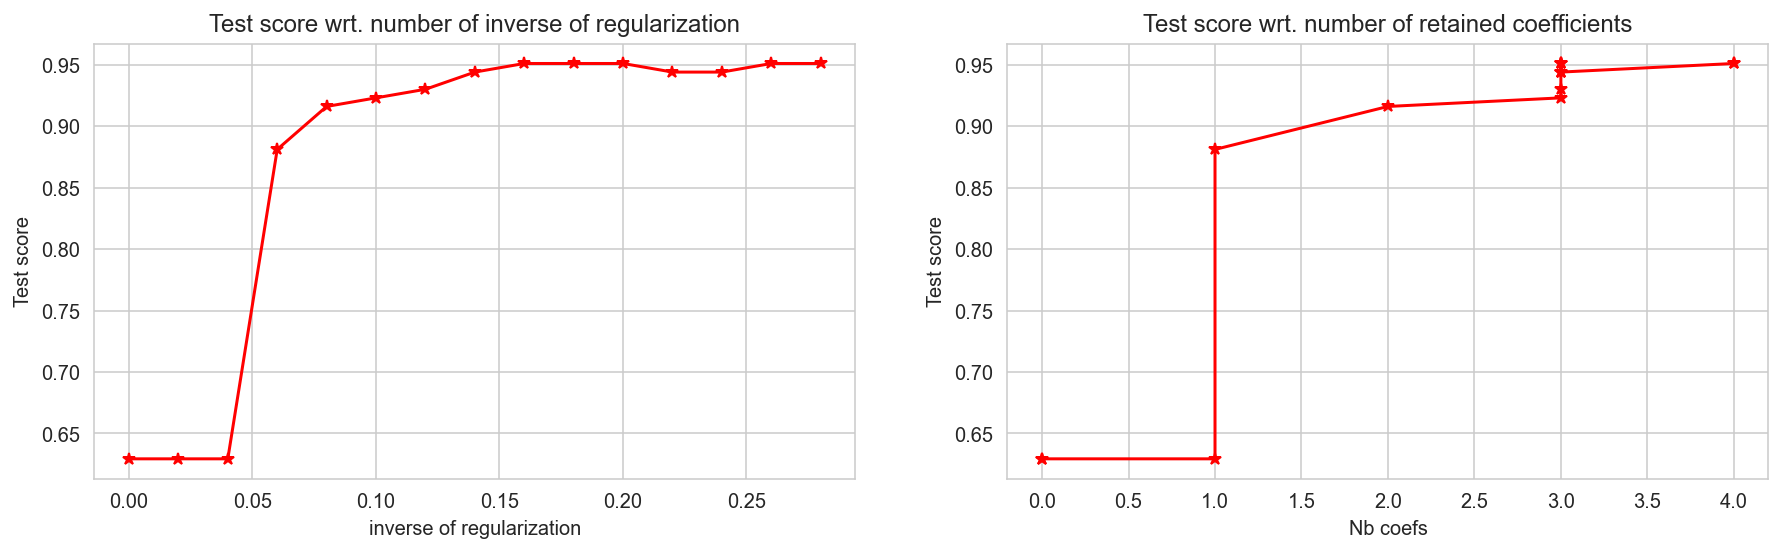

In [17]:
plt.figure(figsize = (15,4))
plt.subplot(121)
plt.plot(Alpha, score_lasso, '-*', color = 'red')
plt.title(r'Test score wrt. number of inverse of regularization')
plt.xlabel('inverse of regularization')
plt.ylabel('Test score');

plt.subplot(122)
plt.plot(nb_features, score_lasso, '-*', color = 'red')
plt.title(r'Test score wrt. number of retained coefficients')
plt.xlabel('Nb coefs')
plt.ylabel('Test score');

The curve on the right shows that using only the 4 most important predictors, the algorithm has more than $90\%$ accuracy, it increases even more when other features are added. 

Exactly knowing which features are the most discriminative can be very helpful to doctors, since they can turn their focus mainly on those features to help them diagnose Breast Cancer. 

In what follows, a second method is presented, which is also based on the $L_1$ penalty.

### 4.2) Support Vector Machine with $\mathcal{L}_1$ penalty
We are interested in the process of selecting the most important variables, and compare the behaviour of two different algorithms, when they are penalized by the same $L_1$ penalty. Do they select the same features? Let us see.

In [18]:
from sklearn.svm import LinearSVC

In [19]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_bc, y_bc, test_size = 0.25, random_state = 0)

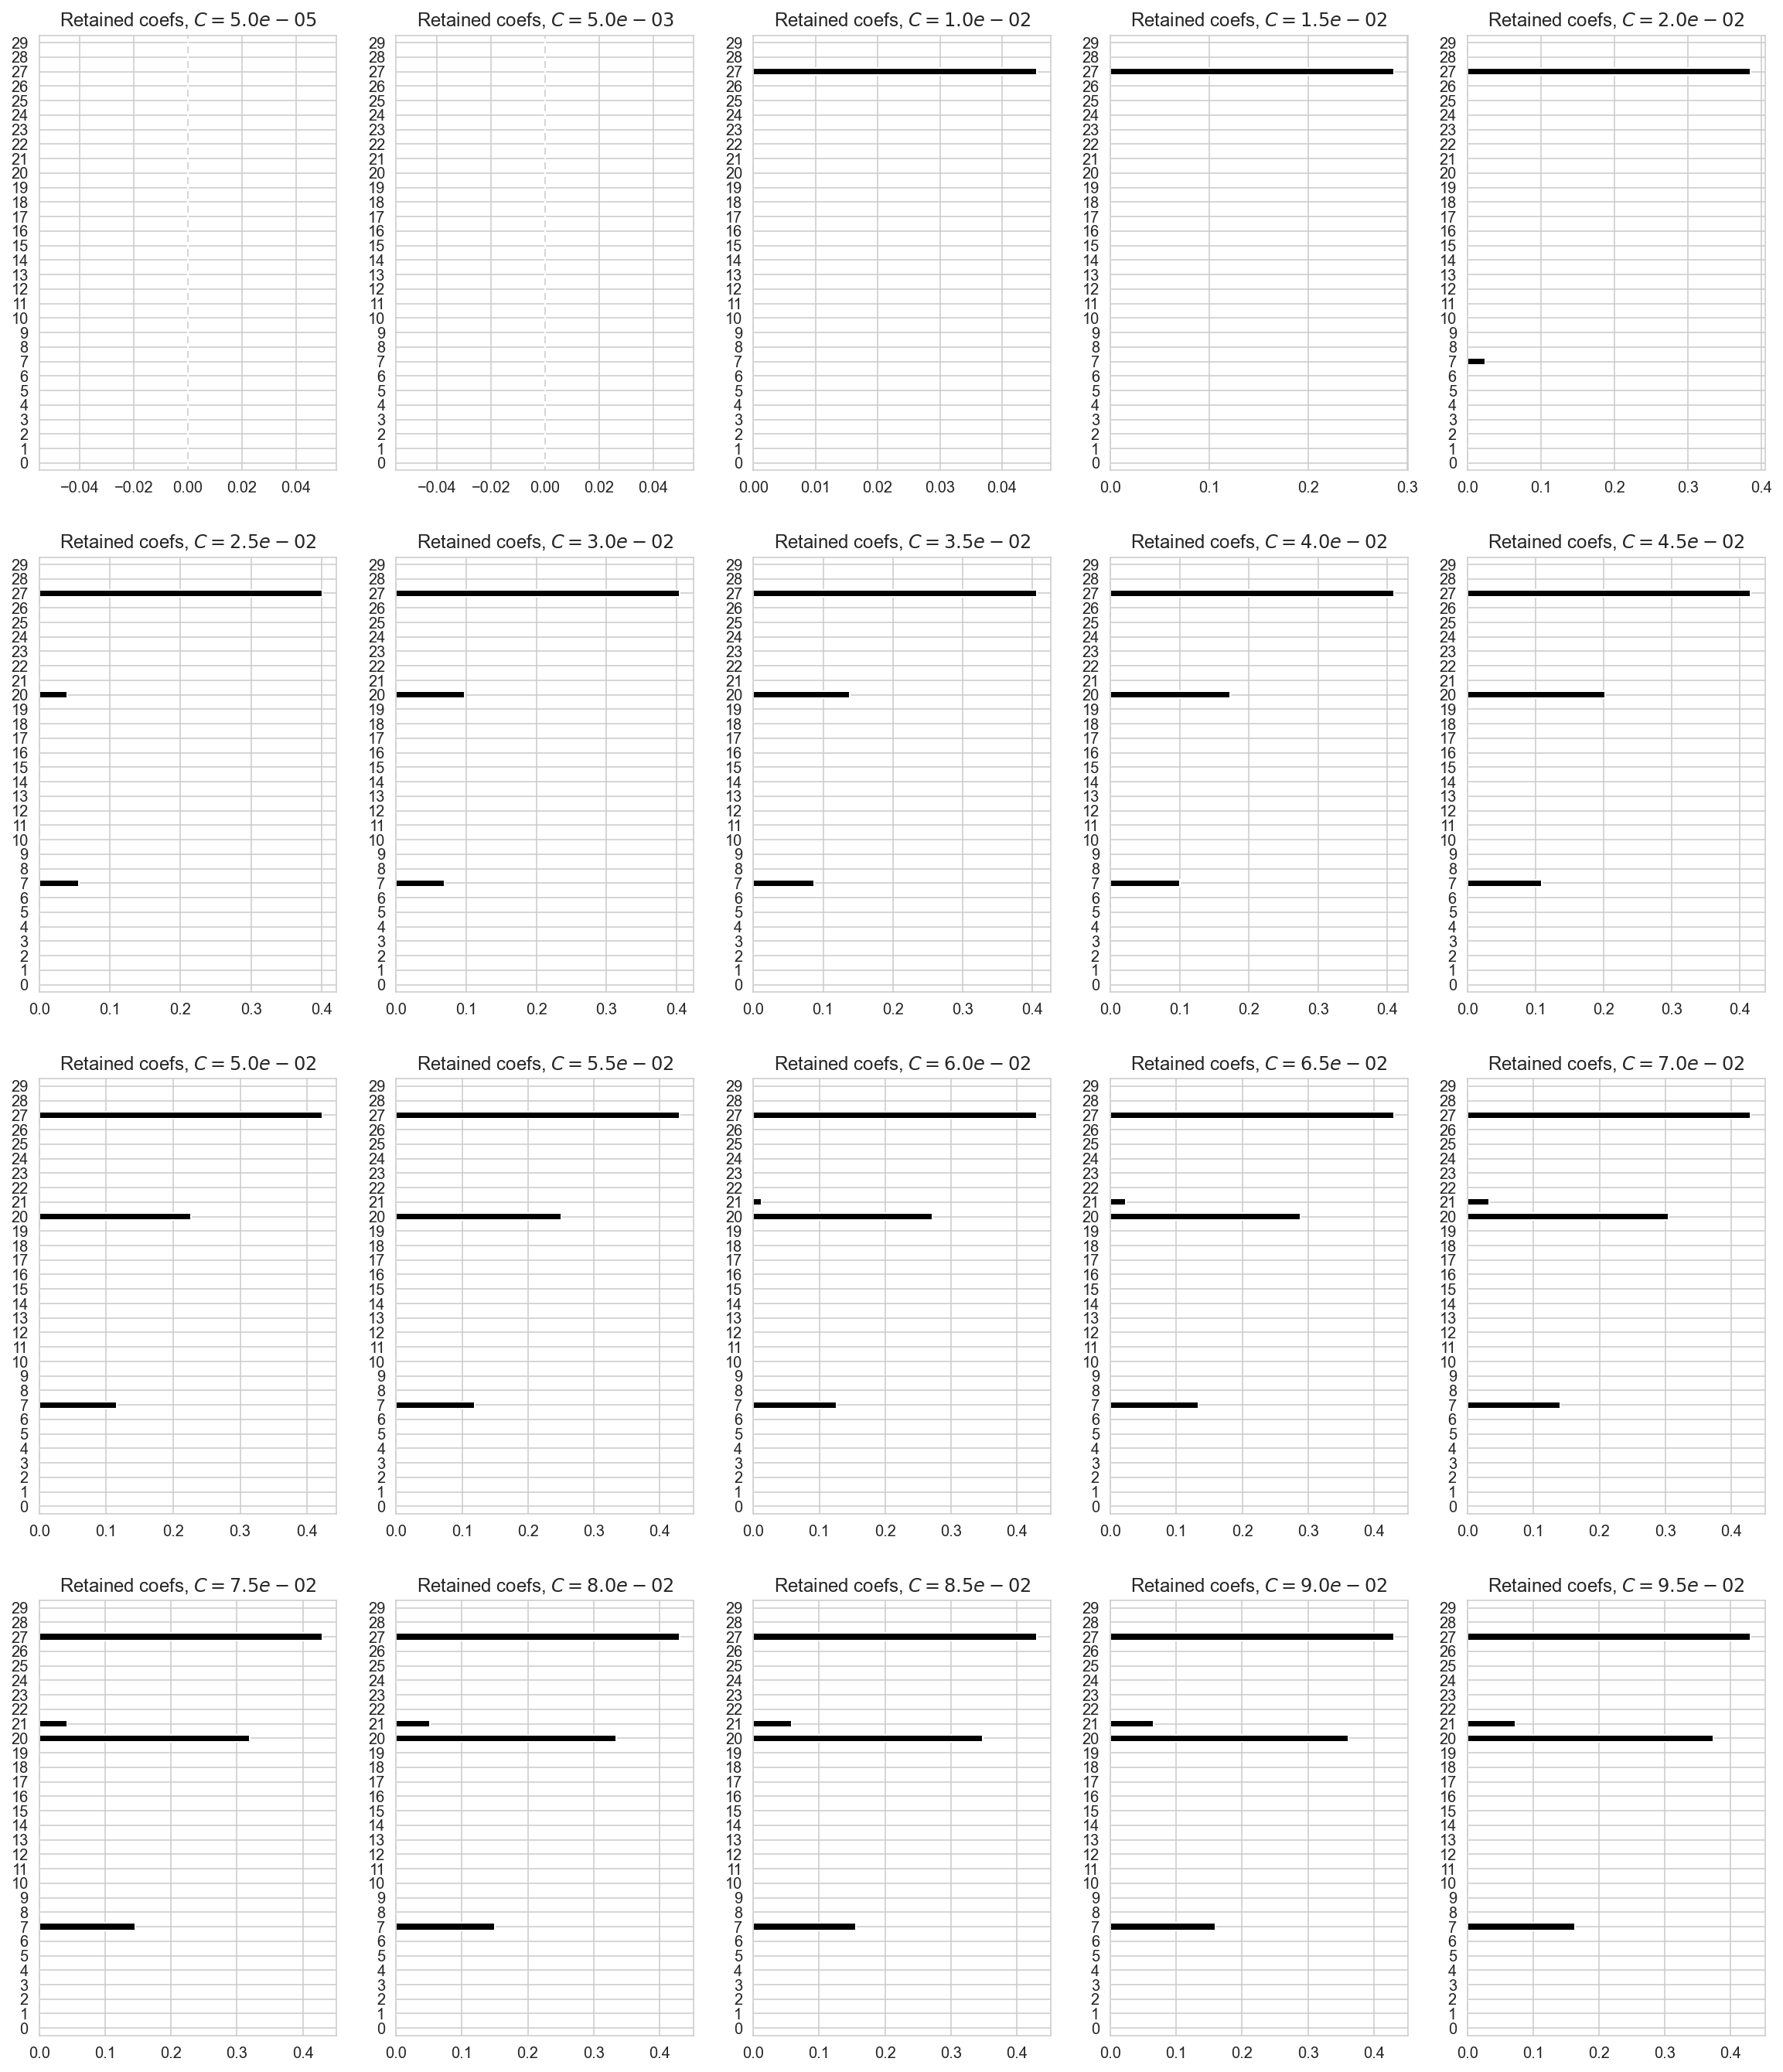

In [20]:
X_std = X_train.std()
C_max = 0.1
C, coefficients = np.arange(5e-5, C_max, 0.005), []
score_svc, nb_features = [], []

plt.figure(figsize = (20,30))
for fig,c in enumerate(C):
    # Fit the Linear SVM estimator
    LSVC = LinearSVC(C = c, penalty = 'l1', dual = False)
    LSVC.fit(X_train, y_train.reshape(-1,))

    # Retrieve the selected coefs
    coefs = pd.Series(LSVC.coef_.reshape(-1,), index = X_train.columns)
    coefficients.append(coefs)
    nb_features.append(np.sum(coefs != 0))
    
    # Compute scores
    score_svc.append(LSVC.score(X_test, y_test))
    
    # Plots
    plt.subplot(5,5, fig+1)
    (X_std * coefs).plot(kind = 'barh', color = 'black')
    plt.title('Retained coefs, $C = %.1e$'%c)

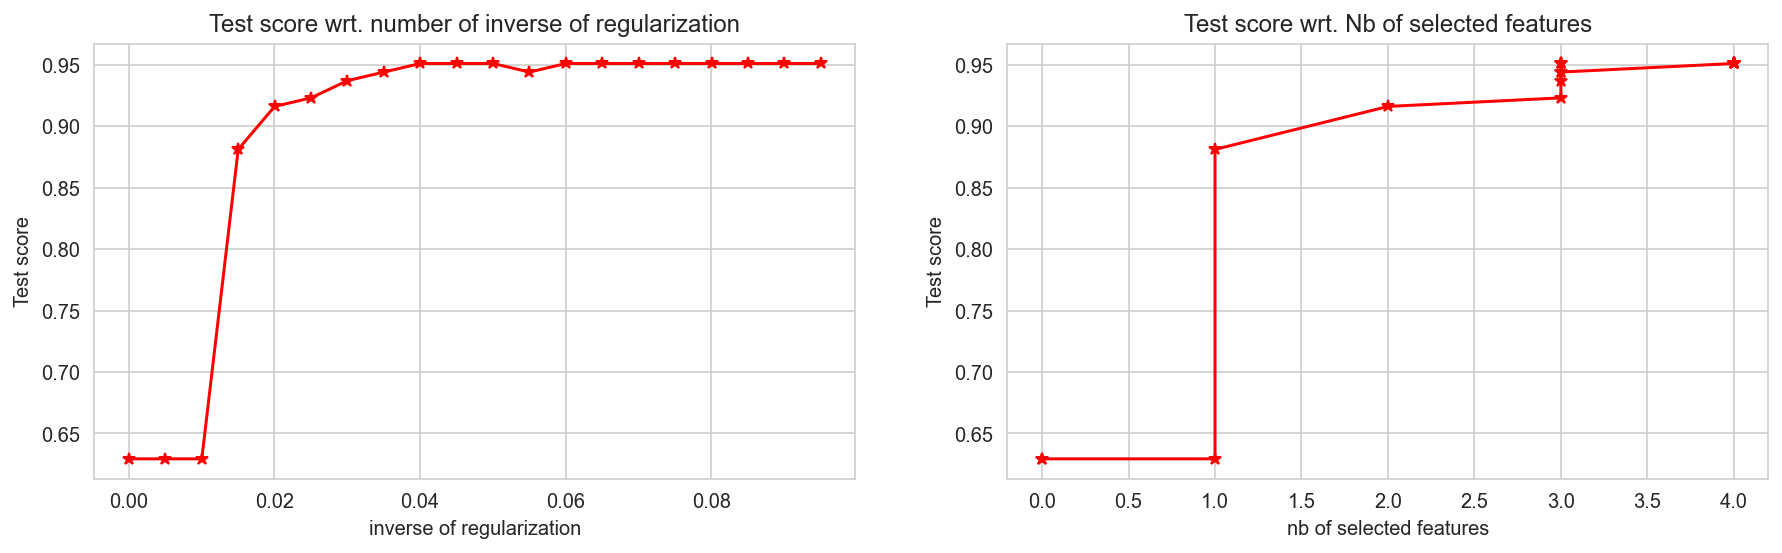

In [21]:
plt.figure(figsize = (15,4))
plt.subplot(121)
plt.plot(C, score_svc, '-*', color = 'red')
plt.title(r'Test score wrt. number of inverse of regularization')
plt.xlabel('inverse of regularization')
plt.ylabel('Test score');

plt.subplot(122)
plt.plot(nb_features, score_svc, '-*', color = 'red')
plt.title(r'Test score wrt. Nb of selected features')
plt.xlabel(r'nb of selected features')
plt.ylabel('Test score');

The same features are selected in the same order, and a similar increase in accuracy is observed when only the 4 most informative features are selected. This highlights the real importance of the selected variables when it comes to discriminate between the patients.

### 4.3) Elastic Net regularization
In what follows, we evaluate the effect of a combined $L_1$ and $L_2$ regularization. The algorithm below is controlled by the `l_1_ratio`, the ration given to the $L_1$ penalty. The solution becomes more sparse as it increases. Are the same features selected, again?

In [22]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_bc, y_bc, test_size = 0.25, random_state = 0)

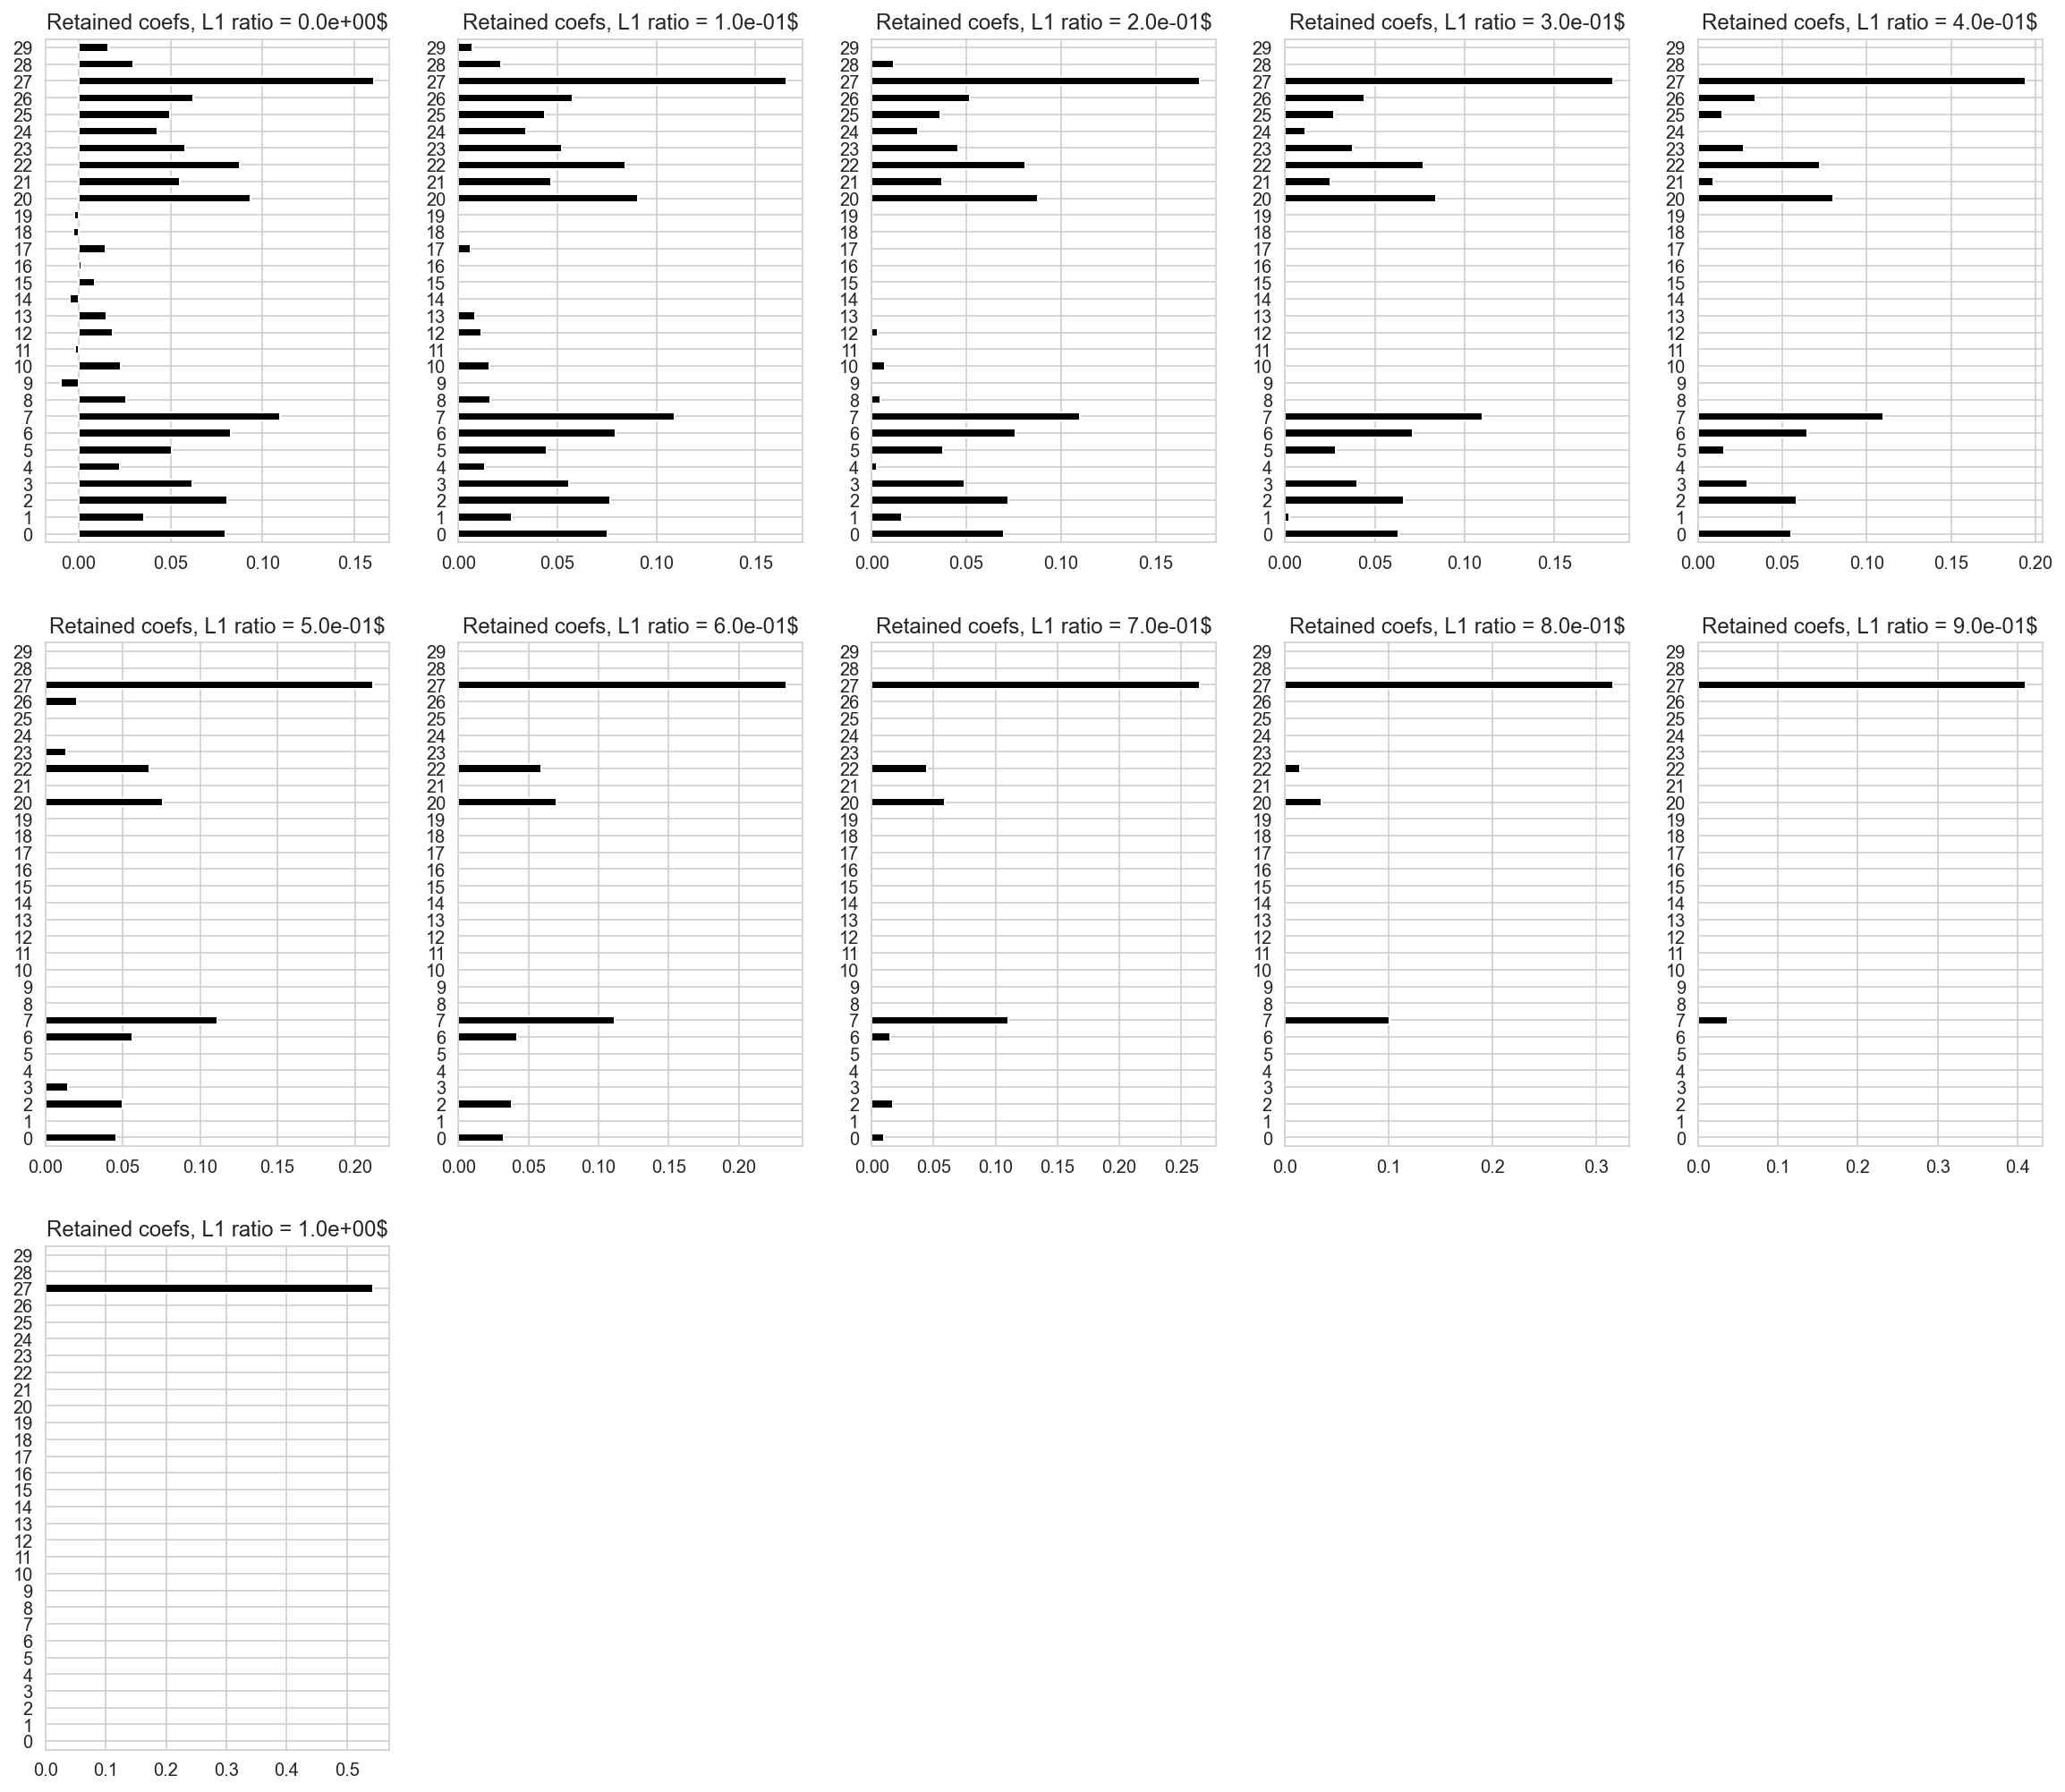

In [23]:
from sklearn.linear_model import ElasticNet

X_std = X_train.std()
ratio_max = 1.1
L1_ratio, coefficients = np.arange(0, ratio_max, 1e-1), []
score_en, nb_features = [], []

plt.figure(figsize = (20,30))
for fig,ratio in enumerate(L1_ratio):
    # Fit the Linear SVM estimator
    EN = LogisticRegression(l1_ratio = ratio, penalty = 'elasticnet', solver = 'saga', max_iter = 5000, C = 4e-2)
    EN.fit(X_train, y_train.reshape(-1,))

    # Retrieve the selected coefs
    coefs = pd.Series(EN.coef_.reshape(-1,), index = X_train.columns)
    coefficients.append(coefs)
    nb_features.append(np.sum(coefs != 0))
    
    # Compute scores
    score_en.append(EN.score(X_test, y_test))
    
    # Plots
    plt.subplot(5,5, fig+1)
    (X_std * coefs).plot(kind = 'barh', color = 'black')
    plt.title(r'Retained coefs, L1 ratio = %.1e$'%ratio)

The 4 features mentionned above are the last to disappear as the $L_1$ ratio becomes larger, which, again, highlights their importance into the decision-making process of the Logistic Regression algorithm.

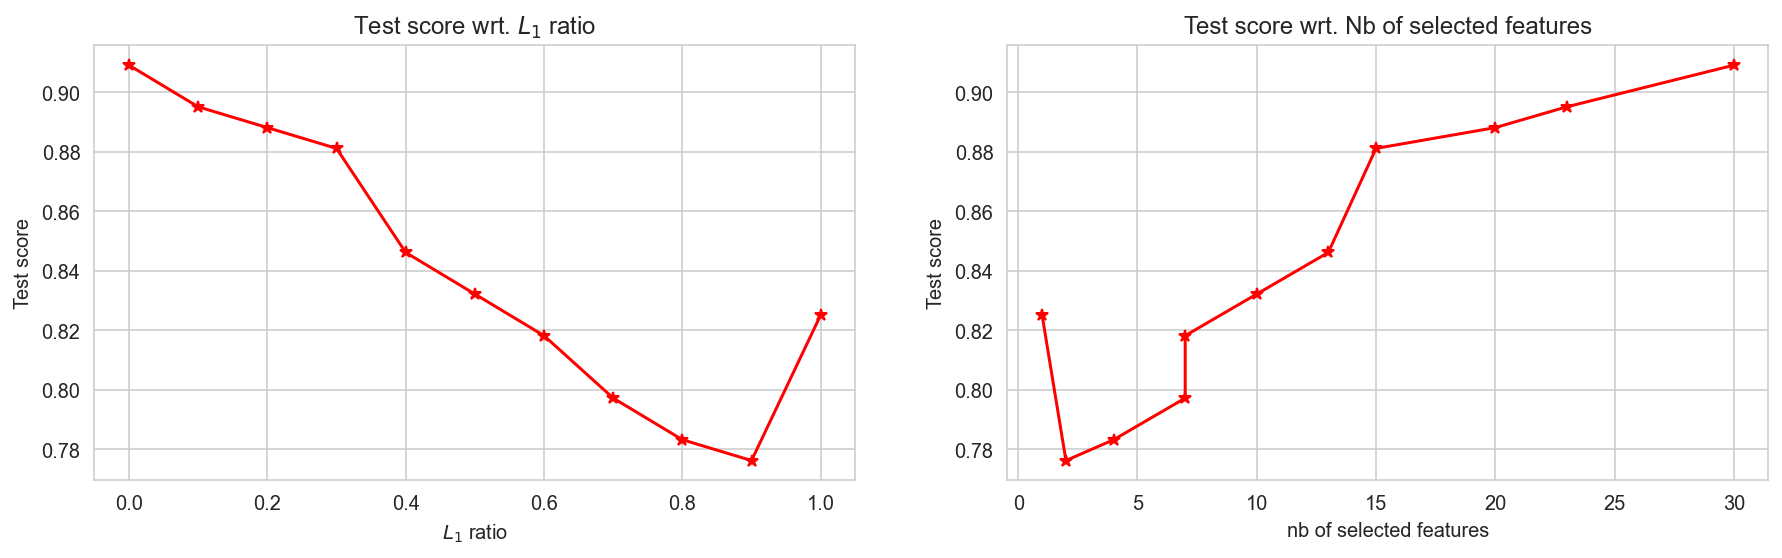

In [24]:
plt.figure(figsize = (15,4))
plt.subplot(121)
plt.plot(L1_ratio, score_en, '-*', color = 'red')
plt.title(r'Test score wrt. $L_1$ ratio')
plt.xlabel(r'$L_1$ ratio')
plt.ylabel('Test score');

plt.subplot(122)
plt.plot(nb_features, score_en, '-*', color = 'red')
plt.title(r'Test score wrt. Nb of selected features')
plt.xlabel(r'nb of selected features')
plt.ylabel('Test score');

We finish this first part of the lab by observing that adding a $L_2$ regularization further affects the accuracy of the algorithms, it can be observed from the $78\%$ accuracy we get using only the 4 main features compared to the $92 \%$ we get when no $L_2$ penalty is applied. On the other hand, this penalty has no role to play when it comes to feature selection. The latter is mainly controlled by the $L_1$ penalty term, since it is responsible for having sparse solutions. 

The Breast Cancer Diagnosis in, at the end, controlled by 4 main features, that are revealed to be very informative. The second part is about a much larger data set, containing thousands of gene expressions, used as features, the aim is to identify the most informative gene expressions among the initially given features.


# II. Molecular classification of leukemia data set
___
We start by importing the data set and display the number of initial features. We also make a quick check to see if the classes are balanced or not. If not, adequate algorithms and methods have to be applied. 

In [25]:
X_golub = pd.read_csv('data/Golub_X',sep=' ', header = None) # Observations
y_golub = pd.read_csv('data/Golub_y',sep=' ', header = None) # Classes

In [26]:
X_golub.head()

,0,1,2,3,4,5,6,7,8,9,...,3552,3553,3554,3555,3556,3557,3558,3559,3560,3561
0,0.708071,0.928074,0.553591,0.449212,0.363766,0.391414,0.166499,0.857143,0.502732,0.922851,...,0.273764,0.472789,0.515213,0.394261,0.402418,0.268886,0.161897,0.322954,0.754658,0.570896
1,0.405266,0.577726,0.619890,0.811734,0.516405,0.333333,0.088141,0.629344,0.273224,0.874796,...,0.644487,0.243197,0.251521,0.362380,0.133015,0.477593,0.182673,0.318060,0.677019,0.656716
2,0.613051,0.821346,0.619890,0.178634,0.553495,0.901515,0.197452,0.943372,0.754098,0.946715,...,0.340304,0.668367,0.444219,0.502657,0.169291,0.709347,0.075265,0.476423,0.770186,0.555970
3,0.684602,0.457077,1.000000,0.515762,0.459344,0.419192,0.179491,0.801802,0.622951,0.949657,...,0.110266,0.460884,0.523327,0.379384,0.166479,0.476312,0.077617,0.249110,0.487578,0.369403
4,0.596451,0.505800,0.770166,0.591944,0.302425,0.691919,0.225215,0.608752,0.344262,0.883295,...,0.152091,0.149660,0.233266,0.526036,0.133577,0.357234,0.206978,0.081406,0.686335,0.615672


In [27]:
display(HTML(
    f"Number of attributes: {X_golub.shape[1]} <br/>"
    f"Number of individuals: {X_golub.shape[0]} <br/>"))

In [28]:
display(HTML(
    f"Ratio of class 0: {(y_golub[y_golub==0].count().values / y_golub.count().values)[0]} <br/>"
    f" The classes are roughly balanced, classic algorithms can be used.<br/>"
))

The same scheme is applied, that is to try the Variance Threshold and the FDR methods, and then to move to the embedded methods, which are based on the $L_1$ penalty.
## 1. Classifiction using the whole data set

In [29]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_golub, y_golub, test_size = 0.2, random_state = 0)

In [30]:
svc2 = SVC(C = 1, kernel = 'linear', probability = True)
svc2.fit(X_train, y_train.to_numpy().reshape(-1,))

SVC(C=1, kernel='linear', probability=True)

In [31]:
k = 3
cv2 = cross_validate(svc2, X_train, y_train, cv = k,
                     scoring = ['balanced_accuracy', 'roc_auc_ovr_weighted', 'accuracy'],
                     n_jobs = -1)

In [32]:
display(HTML(
    f"3-fold cross-validation: <br/>"
    f"Balanced Accuracy: {cv2['test_balanced_accuracy']} <br/>"
    f"Balanced roc_auc: {cv2['test_roc_auc_ovr_weighted']} <br/>"
    f"Accuracy: {cv2['test_accuracy']} <br/>"
))

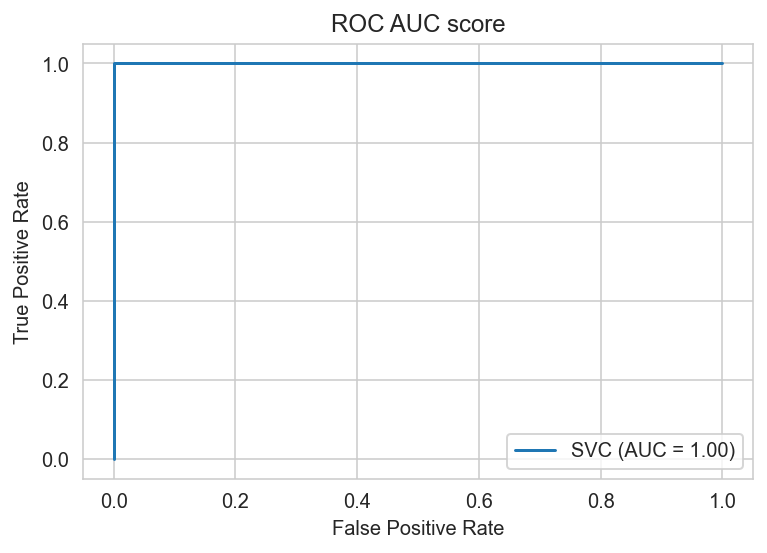

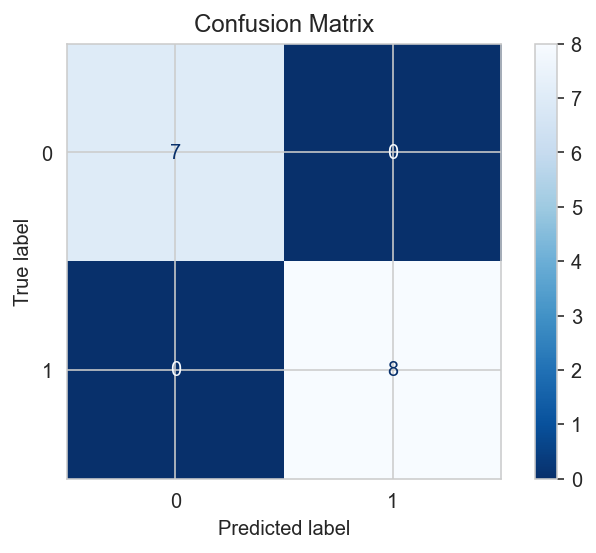

In [33]:
plot_roc_curve(svc2, X_test, y_test)
plt.title('ROC AUC score')

plot_confusion_matrix(svc2, X_test, y_test, cmap = 'Blues_r')
plt.title('Confusion Matrix');

A linear SVM makes no error when it comes to the test data set, let us see if this performance is degraded when less features are used.
## 2. Filter Methods

In [34]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_golub, y_golub, test_size = 0.2, random_state = 0)

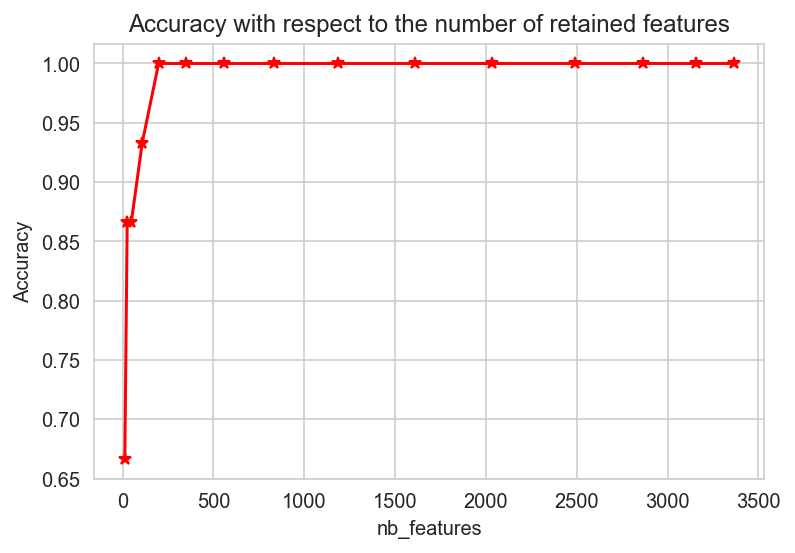

In [35]:
threshold = [k*X_golub.var().mean() for k in np.arange(0.5,2.,0.1)]
accuracy, nb_features = [], []

for thd in threshold:
    # Fit the variance threshold selector
    selector = VarianceThreshold(threshold = thd)
    selector.fit_transform(X_train)
    idx = selector.get_support(indices = True)
    X_new = X_train.copy()
    X_new.loc[:,~X_new.columns.isin(idx)] = 0
    nb_features.append(idx.shape[0])
    
    # Display the selected number of features 
    display(HTML(
    f"threshold: {thd} <br/>"
    f"Number of retained features: {idx.shape[0]} <br/>"
    ))
    
    # Fit the classifier
    svc = SVC(C = 1, kernel = 'linear', probability = True)
    svc.fit(X_new, y_train.to_numpy().reshape(-1,))
    accuracy.append(svc.score(X_test, y_test))

    
# Plot the accuracy
plt.plot(nb_features, accuracy, '-*', color = 'red')
plt.xlabel('nb_features')
plt.ylabel('Accuracy')
plt.title('Accuracy with respect to the number of retained features');

With using only 198 of the available 3562 features, we are able to correctly classify all the individuals. This is very important since we are able to drastically reduce the number of predictors and to get similar results. We will se in the next section that we can further decrease the number of selected variables, at the cost of a small loss in accuracy.

## 3. Statistical tests

In [36]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_golub, y_golub, test_size = 0.20, random_state = 0)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

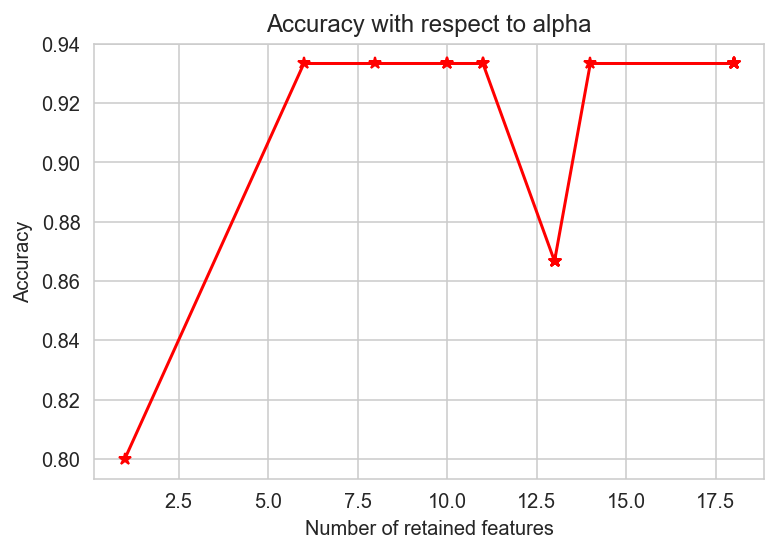

In [37]:
accuracy, nb_features, indices  = [], [], []
alpha = np.arange(1e-6, 2e-4, 1e-5)

for alph in alpha:
    # Fit the False Discovery Rate selector
    selector_fdr = SelectFdr(score_func = f_classif, alpha = alph)
    selector_fdr.fit(X_train, y_train.reshape(-1,))
    idx = selector_fdr.get_support(indices = True)
    X_new = X_train.copy()
    X_new.loc[:,~X_new.columns.isin(idx)] = 0
    nb_features.append(idx.shape[0])
    indices.append(selector_fdr.get_support(indices = True))
    
    # Display the selected number of features 
    display(HTML(
    f"Alpha: {alph} <br/>"
    f"Number of retained attributes: {idx.shape[0]} <br/>"
    f"Retained indices: {idx} <br/>"
    ))
    
    # Fit the classifier
    svc = SVC(C = 1, kernel = 'linear', probability = True)
    svc.fit(X_new, y_train.reshape(-1,))
    accuracy.append(svc.score(X_test, y_test))

    
# Plot the accuracy
plt.plot(nb_features, accuracy, '-*', color = 'red')
plt.xlabel('Number of retained features')
plt.ylabel('Accuracy')
plt.title('Accuracy with respect to alpha');

With only 6 of the initial 3562 features, a linear SVM is able to predict more than $93\%$ of the test data, which is totally acceptable given that a very reduced set of variables are selected. Can we get a better selection using the embedded methods? 

## 4. $\mathcal{L}_1$- based feature selection
Here again, the $L_1$ penalty is applied to select the most discriminative variables.
### 4.1) Logistic Regression with $\mathcal{L}_1$ penalty (LASSO)

In [38]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_golub, y_golub, test_size = 0.20, random_state = 0)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [39]:
X_std = X_train.std()
alph_max = 3
Alpha, coefficients = np.arange(1e-5, alph_max, 0.3), []
score_lasso, nb_features = [], []

for fig,alph in enumerate(Alpha):
    # Fit the LASSO estimator
    lasso = LogisticRegression(C = alph, penalty = 'l1', solver = 'liblinear')
    lasso.fit(X_train, y_train.reshape(-1,))
    
    # Retrieve the selected coefs and their indices
    coefs = pd.Series(lasso.coef_.reshape(-1,), index = X_train.columns)
    coefficients.append(coefs)
    idx = np.where(coefs != 0)
    nb_features.append(np.sum(coefs != 0))
    
    # Display the selected number of features 
    display(HTML(
    f"Alpha: {alph} <br/>"
    f"Number of retained attributes: {(np.sum(coefs != 0))} <br/>"
    f"Retained indices: {idx[0]} <br/>"
    ))
    
    # Compute scores
    score_lasso.append(lasso.score(X_test, y_test))

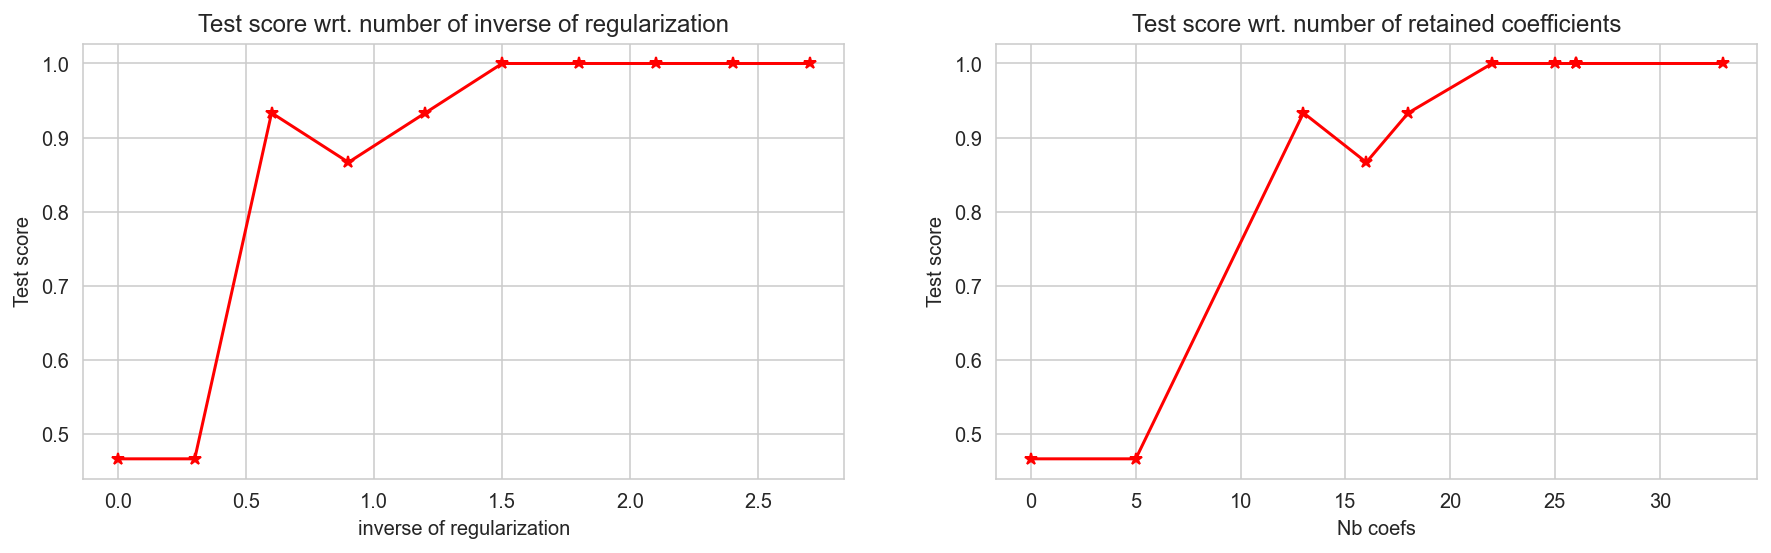

In [40]:
plt.figure(figsize = (15,4))
plt.subplot(121)
plt.plot(Alpha, score_lasso, '-*', color = 'red')
plt.title(r'Test score wrt. number of inverse of regularization')
plt.xlabel('inverse of regularization')
plt.ylabel('Test score');

plt.subplot(122)
plt.plot(np.sort(nb_features), score_lasso, '-*', color = 'red')
plt.title(r'Test score wrt. number of retained coefficients')
plt.xlabel('Nb coefs')
plt.ylabel('Test score');

A $100\%$ accuracy can be achieved using a small subset of the variables. It is also interesting to note that the features selected by the LASSO algorithm differ from the ones selected by the Variance Threshold and the FDR methods. It is totally understandable since the LASSO's feature selection process is very different from the previous methods. What is also interesting is that all the $L_1$ based methods select almost the same variables, which is quite reassuring.

### 4.2) Support Vector Machine with $\mathcal{L}_1$ penalty

In [41]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_golub, y_golub, test_size = 0.20, random_state = 0)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [42]:
X_std = X_train.std()
C_max = 3
C, coefficients = np.arange(5e-5, C_max, 0.2), []
score_svc, nb_features = [], []

for fig,c in enumerate(C):
    # Fit the Linear SVM estimator
    LSVC = LinearSVC(C = c, penalty = 'l1', dual = False, max_iter = 5000)
    LSVC.fit(X_train, y_train.reshape(-1,))

    # Retrieve the selected coefs
    coefs = pd.Series(LSVC.coef_.reshape(-1,), index = X_train.columns)
    coefficients.append(coefs)
    idx = np.where(coefs != 0)
    nb_features.append(np.sum(coefs != 0))
    
    # Display the selected number of features 
    display(HTML(
    f"Inverse of regularization: {c} <br/>"
    f"Number of retained attributes: {(np.sum(coefs != 0))} <br/>"
    f"Retained indices: {idx[0]} <br/>"
    ))
    
    # Compute scores
    score_svc.append(LSVC.score(X_test, y_test))

/Users/bedisjaouani/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


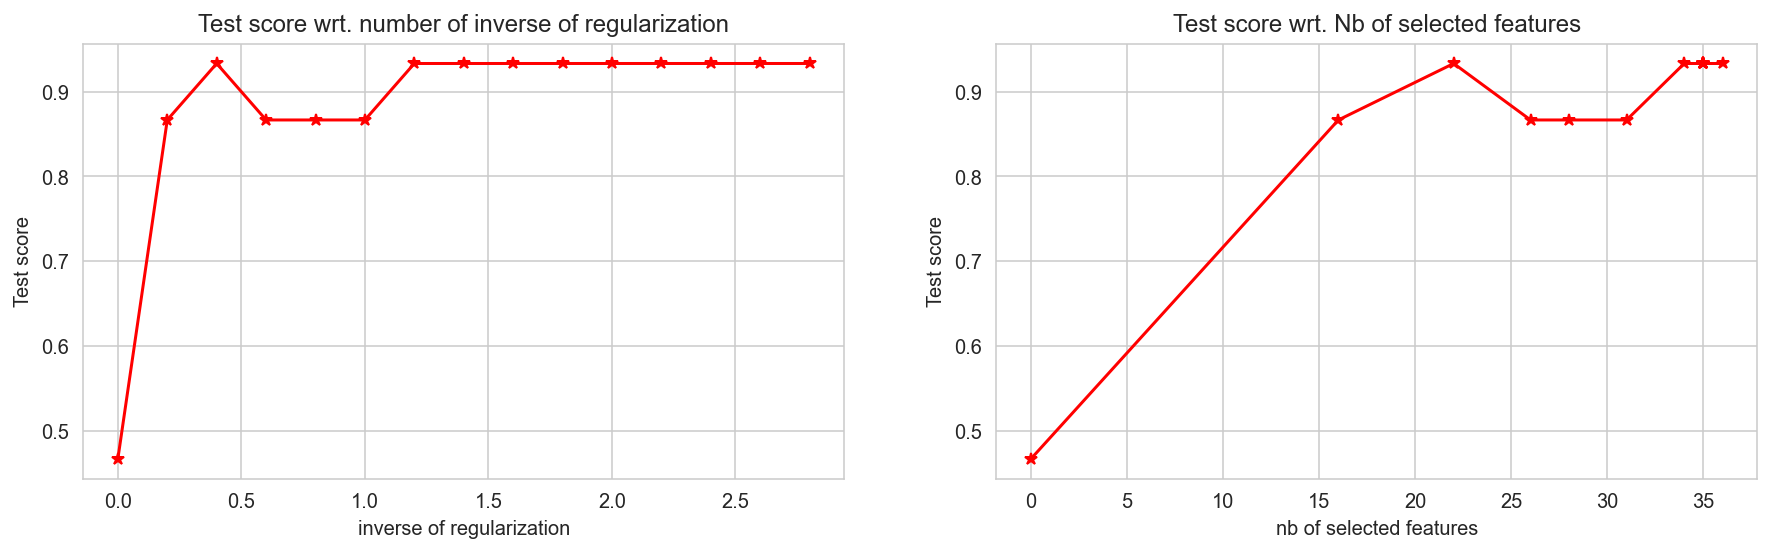

In [43]:
plt.figure(figsize = (15,4))
plt.subplot(121)
plt.plot(C, score_svc, '-*', color = 'red')
plt.title(r'Test score wrt. number of inverse of regularization')
plt.xlabel('inverse of regularization')
plt.ylabel('Test score');

plt.subplot(122)
plt.plot(np.sort(nb_features), score_svc, '-*', color = 'red')
plt.title(r'Test score wrt. Nb of selected features')
plt.xlabel(r'nb of selected features')
plt.ylabel('Test score');

A very high accuracy is achieved, here again, using a small subset of features. Like we've mentionned, there is a coherence between the selected variables by an SVM and a Logistic Regression algorithm, when penalized by the $L_1$ norm.
### 4.3) Elastic Net regularization

In [44]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_golub, y_golub, test_size = 0.20, random_state = 0)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [45]:
X_std = X_train.std()
ratio_max = 1.1
L1_ratio, coefficients = np.arange(0, ratio_max, 1e-1), []
score_en, nb_features = [], []

plt.figure(figsize = (20,30))
for fig,ratio in enumerate(L1_ratio):
    # Fit the Linear SVM estimator
    EN = LogisticRegression(C = 1, penalty = 'elasticnet', solver = 'saga', l1_ratio = ratio, max_iter = 5500)
    EN.fit(X_train, y_train.reshape(-1,))

    # Retrieve the selected coefs
    coefs = pd.Series(EN.coef_.reshape(-1,), index = X_train.columns)
    coefficients.append(coefs)
    idx = np.where(coefs != 0)
    nb_features.append(np.sum(coefs != 0))
    
    # Display the selected number of features 
    display(HTML(
    f"L1 regularization ratio: {ratio} <br/>"
    f"Number of retained attributes: {(np.sum(coefs != 0))} <br/>"
    #f"Retained indices: {idx[0]} <br/>"
    ))
    
    # Compute scores
    score_en.append(EN.score(X_test, y_test))

<Figure size 1440x2160 with 0 Axes>

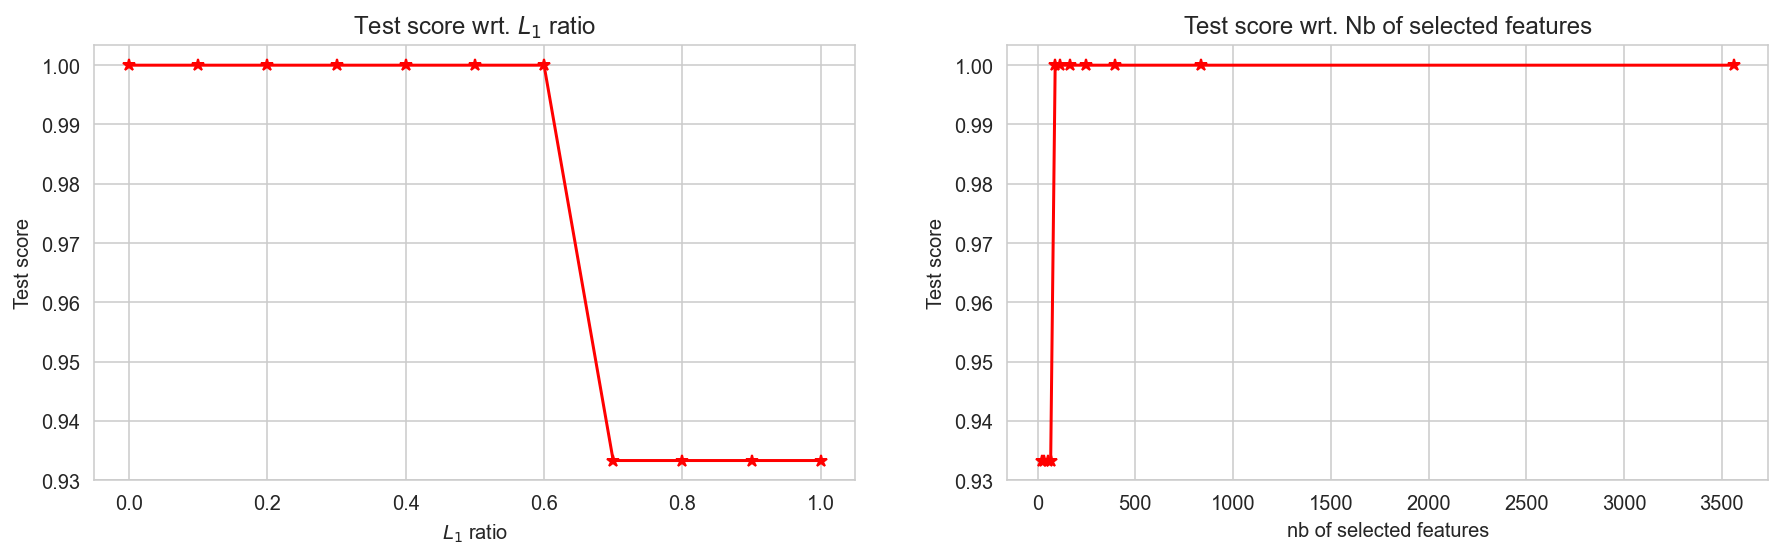

In [46]:
plt.figure(figsize = (15,4))
plt.subplot(121)
plt.plot(L1_ratio, score_en, '-*', color = 'red')
plt.title(r'Test score wrt. $L_1$ ratio')
plt.xlabel(r'$L_1$ ratio')
plt.ylabel('Test score');

plt.subplot(122)
plt.plot(nb_features, score_en, '-*', color = 'red')
plt.title(r'Test score wrt. Nb of selected features')
plt.xlabel(r'nb of selected features')
plt.ylabel('Test score');

When using Elastic Net regularization, more features have to be selected (90 in this case) in order to obtain a $100\%$ accuracy, which is much lower than the initial 3562 variables.

# Conclusion
___
On the given data sets, embedded methods turn to be very coherent in their choice of the reduced number of variables. The $L_1$ penalty behaves in a similar way when applied to conceptually two different classification algorithms, the results that we presented show that the features have similar importances in the case of $L_1$ penalized SVM and Logistic Regression.

Feature selection has proven to be very important, espacially when the data set initially contains a very high number of variables. It helps detecting the most discriminative features, and building highly efficient classification algorithms only based on these features. 

From a practical point of view, the selected variables correspond to measurements or molecular concentrations, which give hints to the scientists or doctors in order to diagnose diseases for example. 

Finally, methods based on thresholds, or statistical tests give different results, it could be interesting to further explore the variables that are only selected by these methods, but in general, a LASSO approach is preferred in many Machine Learning applications. However, thresholding methods do not require the labels of the data, meaning that they can be used in unsupervised learning, which turns to be very useful in many applications. 